kaggleコンペpetfinder　https://www.kaggle.com/c/petfinder-adoption-prediction
をfastaiやpytorch Lightningのような
ラッパーライブラリなしで実装したノートブック

参照
https://www.kaggle.com/yasufuminakama/petfinder-efficientnet-b0-starter-training

# Training efficientnet_b0

## 準備

### Library

In [1]:
import os
import gc
import sys
import math
import time
import random
import shutil
import seaborn as sns
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as transforms
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM

sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
import timm
import lightgbm as lgb

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

OUTPUT_DIR = './my_model/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

### Config

In [2]:
class CFG:
    apex=False
    debug=False
    print_freq=10
    num_workers=4
    size=512
    model_name='tf_efficientnet_b0_ns'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=3
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=3 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=16
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=1
    target_col='Pawpularity'
    n_fold=2
    trn_fold=[0, 1]
    train=True
    grad_cam=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

### wandb

In [3]:
# ====================================================
# wandb
# ====================================================
import wandb
wandb.login

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="petfinder_myproject", 
                 config=class2dict(CFG),
                 job_type="train")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cashunsukechiba (use `wandb login --relogin` to force relogin)


## 前処理

### deta load

In [4]:
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')

def get_train_file_path(image_id):
    return "../input/petfinder-pawpularity-score/train/{}.jpg".format(image_id)

def get_test_file_path(image_id):
    return "../input/petfinder-pawpularity-score/test/{}.jpg".format(image_id)

train['file_path'] = train['Id'].apply(get_train_file_path)
test['file_path'] = test['Id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,file_path
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,../input/petfinder-pawpularity-score/test/4128...
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,../input/petfinder-pawpularity-score/test/43a2...
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,../input/petfinder-pawpularity-score/test/4e42...
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,../input/petfinder-pawpularity-score/test/80bc...
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,../input/petfinder-pawpularity-score/test/8f49...


### CV Split

In [5]:
num_bins = int(np.floor(1+np.log2(len(train))))
train["bins"] = pd.cut(train[CFG.target_col], bins=num_bins, labels=False)
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', "bins"]).size())
train.to_pickle(OUTPUT_DIR+'train.pkl')

fold  bins
0     0        165
      1        209
      2        551
      3       1014
      4        941
      5        650
      6        420
      7        267
      8        203
      9        137
      10        99
      11        70
      12        51
      13       179
1     0        165
      1        209
      2        550
      3       1015
      4        942
      5        649
      6        419
      7        266
      8        203
      9        137
      10        99
      11        70
      12        52
      13       180
dtype: int64

### Function

In [6]:
#seed値を固定
def set_seed(seed =42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
set_seed(seed=CFG.seed)

def get_transforms(*, data):
    if data == 'train':
        return transforms.Compose([
            transforms.RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return transforms.Compose([
            transforms.Resize(CFG.size, CFG.size),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

### Dataset

In [7]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        #cv2は画像読み込みなどに使われるライブラリ
        image = cv2.imread(file_path)
        #色空間を変換
        #TODO 変換しない場合を実験
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

In [8]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

## model

### model

In [9]:
class Model(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.fc = nn.Linear(self.n_features, self.cfg.target_size)

    def feature(self, image):
        feature = self.model(image)
        return feature
        
    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

### Loss

In [10]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

### function



In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

def get_RMSE(y_true,y_pred):
    ## squared=FalseでRSCMになる。※TrueでMSE
    score = mean_squared_error(y_true= y_true ,y_pred=y_pred,squared=False)
    return score

#RSMEを出力
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG.target_col].values
    score = get_RMSE(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}')

def train_fn(fold,train_loader,model,criterion,optimizer,epoch,scheduler,device):
    model.train()
    losses = AverageMeter()
    global_step = 0
    for step,(images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)

        # record loss
        losses.update(loss.item(), batch_size)

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader),                         
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})

def valid_fn(valid_loader, model, criterion, device):
    #推論モードに切り替え
    model.eval()
    losses = AverageMeter()
    preds = []
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


### train loop

In [12]:
def train_loop(folds, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    #dataset
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    #dataloader
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, #TODO why
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    #model
    model = Model(CFG, pretrained=True)
    model.to(device)
    optimizer = Adam(model.parameters(),lr= CFG.lr,weight_decay=CFG.weight_decay,amsgrad=False)
    scheduler = get_scheduler(optimizer)
    criterion = RMSELoss()

    #train loop
    best_score = np.inf
    best_loss = np.inf
    for epoch in range(CFG.epochs):
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # validation
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_RMSE(valid_labels, preds)
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss,
                   f"[fold{fold}] score": score})
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

## main

In [ ]:
def main():
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        #結果を保存
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    wandb.finish()
if __name__ == '__main__':
    main()

# LGB [training]

## 設定

### directory設定

In [13]:
import os

OUTPUT_DIR = './my_model/'
#TODO
MODEL_DIR = './my_model/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

### Config

In [14]:

class CFG:
    num_workers=4
    size=512
    batch_size=16
    model_name='tf_efficientnet_b0_ns'
    seed=42
    target_size=1
    target_col='Pawpularity'
    n_fold=2

### CV split

In [15]:
train = pd.read_pickle('./my_model/train.pkl')

display(train.groupby(['fold', "bins"]).size())

fold  bins
0     0        165
      1        209
      2        551
      3       1014
      4        941
      5        650
      6        420
      7        267
      8        203
      9        137
      10        99
      11        70
      12        51
      13       179
1     0        165
      1        209
      2        550
      3       1015
      4        942
      5        649
      6        419
      7        266
      8        203
      9        137
      10        99
      11        70
      12        52
      13       180
dtype: int64

## Model

### function

In [16]:
def run_single_lightgbm(param, train, features, target, fold=0, categorical=[]):
    #dataload
    train[[f"img_{i}" for i in np.arange(1280)]] = IMG_FEATURES[fold]
    trn_idx = train[train.fold != fold].index
    val_idx = train[train.fold == fold].index
    LOGGER.info(f'train size : {len(trn_idx)}  valid size : {len(val_idx)}')
    if categorical == []:
        trn_data = lgb.Dataset(train.iloc[trn_idx][features].values, label=target.iloc[trn_idx].values)
        val_data = lgb.Dataset(train.iloc[val_idx][features].values, label=target.iloc[val_idx].values)
    else:
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx].values, categorical_feature=categorical)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx].values, categorical_feature=categorical)
    num_round = 10000

    #train
    clf = lgb.train(param, 
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=10,
                    early_stopping_rounds=10)
    LOGGER.info(f'Dumping model with pickle... lightgbm_fold{fold}.pkl')
    with open(OUTPUT_DIR+f'lightgbm_fold{fold}.pkl', 'wb') as fout:
        #モデルをシリアライズ化して保存
        pickle.dump(clf, fout)
    
    #予測
    oof = np.zeros(len(train))
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    score = get_RMSE(target.iloc[val_idx].values, oof[val_idx])
    LOGGER.info(f"fold{fold} score: {score:<.5f}")
    
    #future_importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold

    return oof, fold_importance_df, val_idx


def run_kfold_lightgbm(param, train, features, target, n_fold=5, categorical=[]):
    oof = np.zeros(len(train))
    feature_importance_df = pd.DataFrame()
    val_idxes = []
    
    for fold in range(n_fold):
        LOGGER.info(f"===== Fold {fold} =====")
        _oof, fold_importance_df, val_idx = run_single_lightgbm(param, 
                                                                train, features, target, 
                                                                fold=fold, categorical=categorical)
        oof += _oof
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        val_idxes.append(val_idx)
    
    val_idxes = np.concatenate(val_idxes)
    score = get_RMSE(target.iloc[val_idxes].values, oof[val_idxes])
    LOGGER.info(f"CV score: {score:<.5f}")
    
    return oof, feature_importance_df, val_idxes


def show_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
                .groupby("Feature").mean().sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR+'feature_importance_df_lightgbm.png')

def get_features(test_loader, model, device):
    model.eval()
    features = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (images) in tk0:
        images = images.to(device)
        batch_size = images.size(0)
        with torch.no_grad():
            feature = model.feature(images)
        features.append(feature.to('cpu').numpy())
    features = np.concatenate(features)
    return features

In [17]:
IMG_FEATURES = []
test_dataset = TestDataset(train, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, 
                         batch_size=CFG.batch_size * 2, #why?
                         shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
for fold in range(CFG.n_fold):
    model = Model(CFG, pretrained=False)
    state = torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                       map_location=torch.device('cpu'))['model']
    model.load_state_dict(state)
    model.to(device)
    features = get_features(test_loader, model, device)
    IMG_FEATURES.append(features)
    del state; gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

In [19]:
target = train['Pawpularity']
features = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
            'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'] + [f"img_{i}" for i in np.arange(1280)]

lgb_param = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'seed': 42,
    'max_depth': -1,
    'min_data_in_leaf': 10,
    'verbosity': -1,
}

oof, feature_importance_df, _ = run_kfold_lightgbm(lgb_param, 
                                                   train, features, target, 
                                                   n_fold=2, categorical=[])

===== Fold 0 =====
train size : 4956  valid size : 4956


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 19.5751	valid_1's rmse: 20.1284
[20]	training's rmse: 18.6786	valid_1's rmse: 19.7944
[30]	training's rmse: 17.8894	valid_1's rmse: 19.5274
[40]	training's rmse: 17.1941	valid_1's rmse: 19.3325
[50]	training's rmse: 16.5807	valid_1's rmse: 19.1927
[60]	training's rmse: 16.0425	valid_1's rmse: 19.0964
[70]	training's rmse: 15.5728	valid_1's rmse: 19.0271
[80]	training's rmse: 15.1555	valid_1's rmse: 18.9892
[90]	training's rmse: 14.7895	valid_1's rmse: 18.9756
[100]	training's rmse: 14.4619	valid_1's rmse: 18.9734


Dumping model with pickle... lightgbm_fold0.pkl


Early stopping, best iteration is:
[97]	training's rmse: 14.5572	valid_1's rmse: 18.9716


fold0 score: 18.97163
===== Fold 1 =====
train size : 4956  valid size : 4956


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 19.6094	valid_1's rmse: 20.1659
[20]	training's rmse: 18.769	valid_1's rmse: 19.8056
[30]	training's rmse: 18.0366	valid_1's rmse: 19.519
[40]	training's rmse: 17.3943	valid_1's rmse: 19.2998
[50]	training's rmse: 16.8294	valid_1's rmse: 19.1245
[60]	training's rmse: 16.3321	valid_1's rmse: 18.9978
[70]	training's rmse: 15.8938	valid_1's rmse: 18.9055
[80]	training's rmse: 15.5036	valid_1's rmse: 18.8364
[90]	training's rmse: 15.1595	valid_1's rmse: 18.7888
[100]	training's rmse: 14.8526	valid_1's rmse: 18.7591
[110]	training's rmse: 14.5774	valid_1's rmse: 18.7392
[120]	training's rmse: 14.3259	valid_1's rmse: 18.73
[130]	training's rmse: 14.0952	valid_1's rmse: 18.726


Dumping model with pickle... lightgbm_fold1.pkl


[140]	training's rmse: 13.8875	valid_1's rmse: 18.7272
Early stopping, best iteration is:
[131]	training's rmse: 14.0742	valid_1's rmse: 18.7253


fold1 score: 18.72528
CV score: 18.84886


### feature_importance

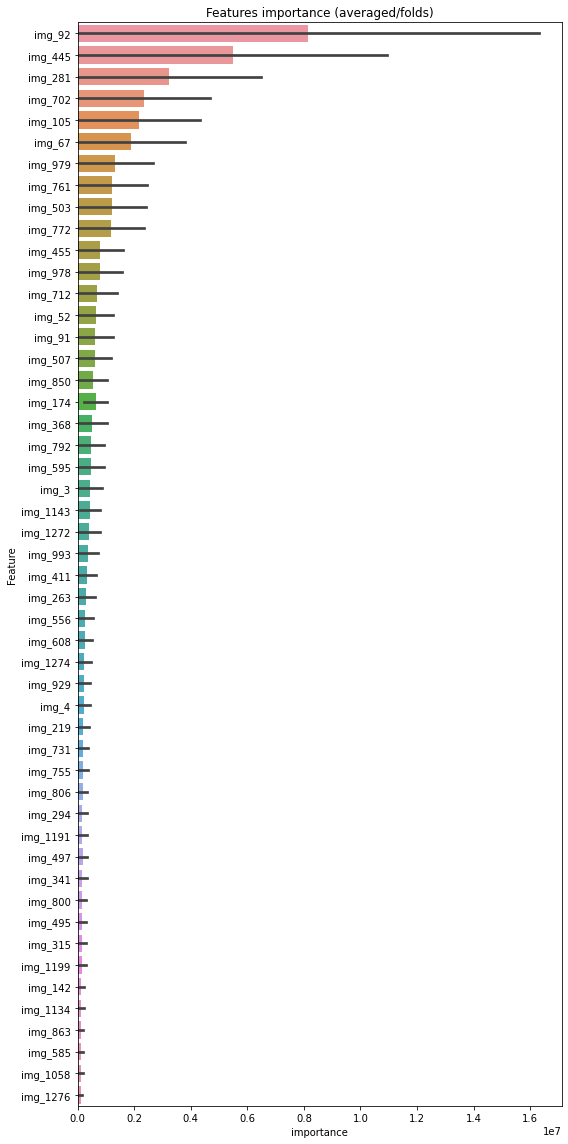

In [20]:
show_feature_importance(feature_importance_df)
feature_importance_df.to_csv(OUTPUT_DIR+f'feature_importance_df.csv', index=False)

### モデル出力

In [21]:
train['pred'] = oof
score = get_RMSE(train['Pawpularity'].values, train['pred'].values)
LOGGER.info(f"CV: {score:<.5f}")
train[['Id', 'Pawpularity', 'pred']].to_pickle(OUTPUT_DIR+'oof.pkl')

CV: 18.84886


# interface

## 初期設定

### dataLoad

In [22]:
def get_test_file_path(image_id):
    return "../input/petfinder-pawpularity-score/test/{}.jpg".format(image_id)

test['file_path'] = test['Id'].apply(get_test_file_path)

display(test.head())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,file_path
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1,../input/petfinder-pawpularity-score/test/4128...
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0,../input/petfinder-pawpularity-score/test/43a2...
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1,../input/petfinder-pawpularity-score/test/4e42...
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0,../input/petfinder-pawpularity-score/test/80bc...
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0,../input/petfinder-pawpularity-score/test/8f49...


In [23]:
OUTPUT_DIR = './my_model/'
MODEL_DIR = './my_model/'
LGB_MODEL_DIR = './my_model//'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [24]:
class CFG:
    num_workers=4
    size=512
    batch_size=16
    model_name='tf_efficientnet_b0_ns'
    seed=42
    target_size=1
    target_col='Pawpularity'
    n_fold=2

## 予測

In [25]:
def inference_single_lightgbm(test, features, model_path, fold):
    test[[f"img_{i}" for i in np.arange(1280)]] = IMG_FEATURES[fold]
    with open(model_path, 'rb') as fin:
        clf = pickle.load(fin)
    prediction = clf.predict(test[features], num_iteration=clf.best_iteration)
    return prediction

In [26]:
IMG_FEATURES = []
test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, 
                         batch_size=CFG.batch_size * 2, 
                         shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
for fold in range(CFG.n_fold):
    model = Model(CFG, pretrained=False)
    state = torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
                       map_location=torch.device('cpu'))['model']
    model.load_state_dict(state)
    model.to(device)
    features = get_features(test_loader, model, device)
    IMG_FEATURES.append(features)
    del state; gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
features = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
            'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'] + [f"img_{i}" for i in np.arange(1280)]

In [29]:
model_paths = [(fold, LGB_MODEL_DIR+f'lightgbm_fold{fold}.pkl') for fold in range(2)]
predictions = [inference_single_lightgbm(test, features, model_path, fold) for fold, model_path in model_paths]
predictions = np.mean(predictions, 0)

In [30]:
test['Pawpularity'] = predictions
test[['Id', 'Pawpularity']].to_csv('submission.csv', index=False)
display(test[['Id', 'Pawpularity']].head())

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,30.787833
1,43a2262d7738e3d420d453815151079e,31.036306
2,4e429cead1848a298432a0acad014c9d,30.787833
3,80bc3ccafcc51b66303c2c263aa38486,30.714812
4,8f49844c382931444e68dffbe20228f4,31.285577
